# Cohort selection

## Problem

We are launching a recommendation tool that identifies vendor cohorts and
suggests performance improvements based on peer comparisons within those
cohorts.  This ad hoc approach creates two risks for our MVP rollout: Weak
statistical foundation: We haven't validated whether our cohorts actually group
similar-performing vendors together Stakeholder confidence: Without a principled
justification for cohort boundaries, leadership are questioning recommendation
validity For more details, see [RFC - Reco cohort updating](https://docs.google.com/document/d/1N57UfysXpHLFVXMAi5htYw2L8hBySiKq9frPIBlvaPk/edit?tab=t.0#heading=h.wcy3kyozl6o0)

## Current cohort rule

Our current cohort rule uses a six-level nested hierarchy (Country → City → Area
→ Price → Cuisine → Grade) that was designed primarily for explainability to
account managers rather than analytical rigor. One shortcoming of the cohort
rule is that when there are an insufficient number of chains in a cohort, the
fallback is often to a broad “All” category. For example, 8% of vendors in the
UAE are in a category with the following dimension values

- Entity: tb_ae 
- City: All 
- Area: All 
- Priciness: All 
- Cuisine: All 
- Vendor Grade: All

Why so many? Our belief is that this is due to the fallback logic. A fallback
occurs when a proposed cohort has too few vendors for reliable comparison. In
the current rule, we switch from a granular cohort to the broadest relevant
cohort with the most chain ids.

## This iteration


## Recommendations 



In [1]:
from pathlib import Path
from cohorts.cohort_statistics import (
    process_dataframes_for_outliers, 
    process_dataframes,
    load_dataframes_by_type
    )
from cohorts.config_manager import TableConfig
from typing import Dict, List, Optional, Tuple
from matplotlib.colors import LinearSegmentedColormap

import os
import warnings
import numpy as np
import pandas as pd
import pandas_gbq
import seaborn as sns
import bigframes.pandas as bpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


%load_ext google.cloud.bigquery
BQ_PROJECT_ID = "dhh-ncr-stg"

# where to save plots
CURRENT_DIR = Path(os.getcwd())
BASE_PLOT_PATH = CURRENT_DIR.parent / "figures" 

TALABAT_ORANGE = '#FF5733'
DH_RED = '#C9332D'  
DH_NAVY = '#3A3FFF'

path_config = TableConfig()

/Users/patrick.doupe/DH/ad_hoc/cohorts/.venv/lib/python3.13/site-packages/google/cloud/bigquery/__init__.py:237: FutureWarning: %load_ext google.cloud.bigquery is deprecated. Install bigquery-magics package and use `%load_ext bigquery_magics`, instead.
  warnings.warn(


## Looking at cohorts

In [2]:
BASE_SQL_QUERY = """
SELECT DISTINCT
  t.cohort_id,
  JSON_VALUE(t.cohort_features, '$.entity') AS entity,
  JSON_VALUE(t.cohort_features, '$.city') AS city,
  JSON_VALUE(t.cohort_features, '$.area') AS area,
  JSON_VALUE(t.cohort_features, '$.budget') AS bugdet,
  JSON_VALUE(t.cohort_features, '$.cuisine') AS cuisine,
  JSON_VALUE(t.cohort_features, '$.vendor_grade') AS vendor_grade,
  JSON_VALUE(t.cohort_features, '$.key_account_sub_category') AS key_account_sub_cat,
  COUNT(t.vendor_code) AS num_vendors
FROM {table_path} AS t
GROUP BY ALL
"""

In [3]:
print("\n===== LOADING 'cohort data' =====")
cohort_data_dfs = load_dataframes_by_type(
    specific_data_type="cohort data",
    base_sql_query_template=BASE_SQL_QUERY,
    config=path_config,
    project_id=BQ_PROJECT_ID
)


===== LOADING 'cohort data' =====
Starting to load 'cohort data' DataFrames...
------------------------------------------------------------
Reading: Key='ys_tr-original-cohort data-current'
  Table Path: logistics-vendor-production.pa_staging.active_vendor_cohorts_original_tr
Downloading: 100%|██████████|
  Successfully loaded 1080 rows.
------------------------------------------------------------
Reading: Key='ys_tr-kasc-no chain-cohort data-current'
  Table Path: logistics-vendor-production.pa_staging.vendor_cohorts_step_3_kasc_no_chain_tr
Downloading: 100%|██████████|
  Successfully loaded 4739 rows.
------------------------------------------------------------
Finished loading 'cohort data' DataFrames.
Total 'cohort data' DataFrames loaded: 2


In [4]:
try:
    current_even_cohort = "base-even-cohort data-current"
    df_bm = cohort_data_dfs[current_even_cohort]
    print(f"\nAccessed DataFrame using key '{current_even_cohort}':")
except KeyError:
    print(f"\nDataFrame with key '{current_even_cohort}' not found (might not have been loaded due to an error).")


DataFrame with key 'base-even-cohort data-current' not found (might not have been loaded due to an error).


In [5]:
try:
    original_even_cohort = "base-even-cohort data-original"
    df_original = cohort_data_dfs[original_even_cohort]
    print(f"\nAccessed DataFrame using key '{original_even_cohort}':")
except KeyError:
    print(f"\nDataFrame with key '{original_even_cohort}' not found (might not have been loaded due to an error).")


DataFrame with key 'base-even-cohort data-original' not found (might not have been loaded due to an error).


In [6]:
try:
    df_bm.sort_values(by='num_vendors', ascending=False).head(20)
except NameError:
    print("Missing data")

Missing data


### Result 1: we have fewer extreme sized cohorts

In [7]:
cohort_size = {}
for key, value in cohort_data_dfs.items():
    tmp_num_cohorts = value.cohort_id.nunique()
    cohort_size[key] = tmp_num_cohorts

(
    pd.DataFrame.from_dict(cohort_size, orient='index', columns=['num_unique_cohorts'])
    .reset_index()
    .sort_values(by='num_unique_cohorts', ascending=False)
)


,index,num_unique_cohorts
1,ys_tr-kasc-no chain-cohort data-current,4739
0,ys_tr-original-cohort data-current,1080


The top four rules by number of cohorts are the uneven weighting rules. Original cohorting rule splits these. 

How many 'big' cohorts do we get?

In [8]:
thresholds = [10, 100, 1000, 10000]
all_cohort_outlier_metrics = [] 

for cohort_rule, df in cohort_data_dfs.items():
    # Pre-calculate num_cohorts once per DataFrame
    num_cohorts = df['cohort_id'].nunique()

    # Handle cases where cohort_id might be empty or all NaNs
    if num_cohorts == 0:
        print(f"Warning: No unique cohorts found for '{cohort_rule}'. Outlier percentages will be 0.")

    for threshold in thresholds:
        # Calculate num_outliers for the current threshold
        num_outliers = df.loc[df['num_vendors'] > threshold].shape[0]

        # Calculate percentage, handling potential division by zero
        pct_outliers = round(100 * num_outliers / num_cohorts, 2) if num_cohorts > 0 else 0

        # Append a dictionary for the current row's data
        all_cohort_outlier_metrics.append({
            'cohort_rule': cohort_rule,
            'threshold': threshold,
            'num_cohorts': num_cohorts,
            'num_outliers': num_outliers,
            'pct_outliers': pct_outliers
        })

df_lge_cohorts = pd.DataFrame(all_cohort_outlier_metrics)

In [9]:
df_lge_cohorts

,cohort_rule,threshold,num_cohorts,num_outliers,pct_outliers
0,ys_tr-original-cohort data-current,10,1080,970,89.81
1,ys_tr-original-cohort data-current,100,1080,306,28.33
2,ys_tr-original-cohort data-current,1000,1080,6,0.56
3,ys_tr-original-cohort data-current,10000,1080,0,0.00
4,ys_tr-kasc-no chain-cohort data-current,10,4739,2233,47.12
5,ys_tr-kasc-no chain-cohort data-current,100,4739,134,2.83
6,ys_tr-kasc-no chain-cohort data-current,1000,4739,1,0.02
7,ys_tr-kasc-no chain-cohort data-current,10000,4739,0,0.00


- Most other cohorting rules work better than original (no cohorts with more than 1000 vendors)
- Excent no chain logic uneven, they even have a cohort with greater than 10k

In [10]:
def plot_num_vendors_boxplots(
    dataframes: Dict[str, pd.DataFrame],
    plot_title: str,
    y_label: str = 'Number of Vendors',
    figure_size: Optional[Tuple[float, float]] = None,
    x_label_rotation: int = 45,
    winsorize_upper_bound: Optional[float] = None,
    save_path: Optional[str] = None, # New: Path to save the figure (e.g., 'plots/my_boxplot.png')
    show_plot: bool = True # New: Control whether to display the plot immediately
) -> None:
    """
    Generates box plots for the 'num_vendors' column across multiple Dataframes.

    Args:
        dataframes (Dict[str, pd.DataFrame]): A dictionary where keys are plot labels
                                              and values are pandas DataFrames, each
                                              expected to have a 'num_vendors' column.
        plot_title (str): The title for the generated box plot.
        y_label (str): The label for the y-axis. Defaults to 'Number of Vendors'.
        figure_size (Optional[Tuple[float, float]]): The size of the figure (width, height) in inches.
                                                   If None, it defaults based on the number of plots.
        x_label_rotation (int): Rotation angle for x-axis labels in degrees.
                                Defaults to 45.
        winsorize_upper_bound (Optional[float]): If provided, 'num_vendors' values
                                                 greater than this bound will be capped
                                                 at this bound for plotting.
                                                 (This is a form of capping/winsorization).
        save_path (Optional[str]): If provided, the plot will be saved to this file path.
                                   Includes directory creation.
        show_plot (bool): If True, calls plt.show() to display the plot immediately.
                          Defaults to True. If saving, you might set this to False.
    """
    data_to_plot: List[pd.Series] = []
    labels: List[str] = []
    skipped_dfs_info: List[str] = []

    for key, df in dataframes.items():
        if 'num_vendors' in df.columns:
            if pd.api.types.is_numeric_dtype(df['num_vendors']) and not df['num_vendors'].empty:
                series_to_plot = df['num_vendors'].copy() # Work on a copy to avoid modifying original DF

                if winsorize_upper_bound is not None:
                    series_to_plot = series_to_plot.clip(upper=winsorize_upper_bound)

                data_to_plot.append(series_to_plot)
                labels.append(key)
            else:
                skipped_dfs_info.append(f"'{key}' (num_vendors not numeric or empty)")
        else:
            skipped_dfs_info.append(f"'{key}' (missing num_vendors column)")

    if skipped_dfs_info:
        print(f"Warning for '{plot_title}': Skipped plotting for:\n- " + "\n- ".join(skipped_dfs_info))

    if not data_to_plot:
        print(f"No valid 'num_vendors' data found for '{plot_title}' to create boxplot.")
        return # Exit if no data to plot

    # Determine figure size if not explicitly provided
    if figure_size is None:
        dynamic_width = max(8, len(labels) * 1.0) # Adjust factor for potentially more compact plots
        figure_size = (dynamic_width, 6)

    fig, ax = plt.subplots(figsize=figure_size) # Use fig, ax for more control

    boxplot_properties = dict(
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', edgecolor='blue'),
        medianprops=dict(color='red'),
        whiskerprops=dict(color='blue'),
        capprops=dict(color='blue')
    )

    ax.boxplot(data_to_plot, tick_labels=labels, **boxplot_properties)

    ax.set_title(plot_title)
    ax.set_ylabel(y_label)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.xticks(rotation=x_label_rotation, ha='right')
    plt.tight_layout()

    # --- New Save and Show Logic ---
    if save_path:
        # Ensure the directory exists
        output_dir = os.path.dirname(save_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"Created directory: {output_dir}")

        plt.savefig(save_path, bbox_inches='tight') # bbox_inches='tight' often helps with clipped labels
        print(f"Plot saved to: {save_path}")

    if show_plot:
        plt.show()
    else:
        # If not showing immediately, explicitly close the figure to free memory
        plt.close(fig)

Plot saved to: /Users/patrick.doupe/DH/ad_hoc/cohorts/figures/original_num_vendors_boxplot.png


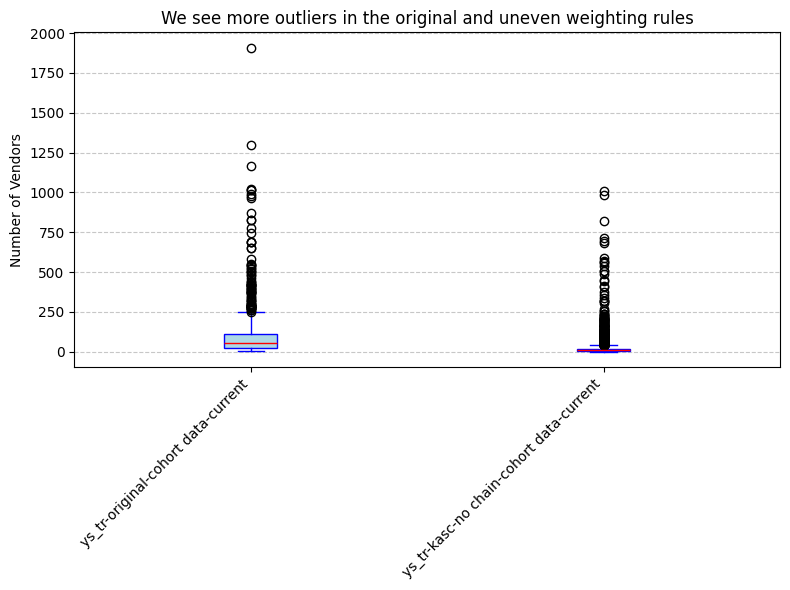

In [11]:
plot_num_vendors_boxplots(
    dataframes=cohort_data_dfs,
    plot_title='We see more outliers in the original and uneven weighting rules',
    y_label='Number of Vendors',
    save_path=BASE_PLOT_PATH / 'original_num_vendors_boxplot.png', # Save the figure
    show_plot=True # Also display it
)


Plot saved to: /Users/patrick.doupe/DH/ad_hoc/cohorts/figures/ty_winsorized_num_vendors_boxplot.png


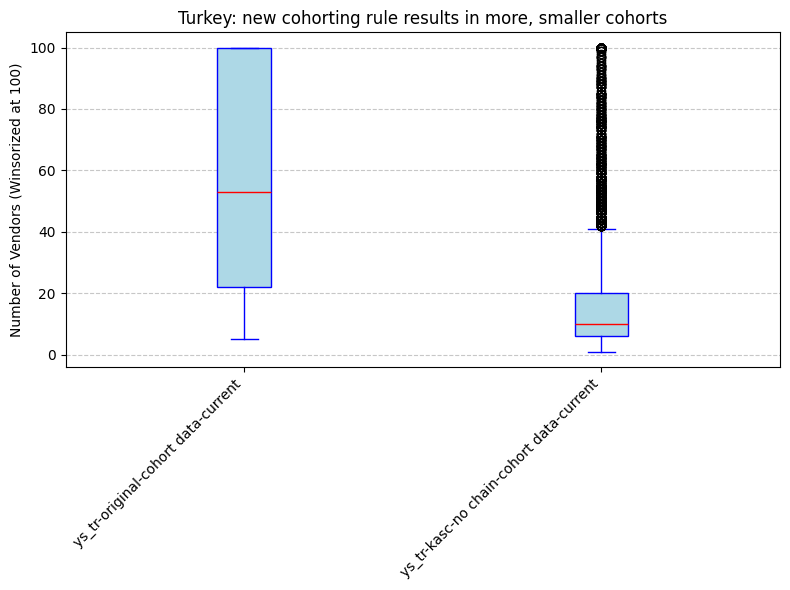

In [12]:
plot_num_vendors_boxplots(
    dataframes=cohort_data_dfs,
    plot_title='Turkey: new cohorting rule results in more, smaller cohorts',
    y_label='Number of Vendors (Winsorized at 100)',
    winsorize_upper_bound=100, 
    save_path=BASE_PLOT_PATH / 'ty_winsorized_num_vendors_boxplot.png', # Save the figure
    show_plot=True # Also display it
)


In [13]:
try:
    cohort_data_dfs['base-even-cohort data-original'].sort_values(by='num_vendors', ascending=False)
except KeyError:
    pass

In [14]:
try:
    cohort_data_dfs['base-even-cohort data-current'].sort_values(by='num_vendors', ascending=False)
except KeyError:
    pass

In [15]:
try:
    cohort_data_dfs['key account segment addition-even-cohort data-current']
except KeyError:
    pass

In [16]:
try:
    cohort_data_dfs['key account segment addition-even-cohort data-current'].sort_values(by='num_vendors', ascending=False)
except KeyError:
    pass

In [17]:
try:
    cohort_data_dfs['no chain logic-even-cohort data-current'].sort_values(by='num_vendors', ascending=True)
except KeyError:
    pass

In [18]:
try:
    cohort_data_dfs['no chain logic-even-cohort data-current'].sample(n=20)
except KeyError:
    pass

In [19]:
try:
    cohort_data_dfs['key account no chain-even-cohort data-turkey'].sort_values(by='num_vendors', ascending=False)
except KeyError:
    pass

In [20]:
try:
    cohort_data_dfs['key account no chain-even-cohort data-current'].sort_values(by='num_vendors', ascending=False)
except KeyError:
    pass

In [21]:
for key, val in cohort_data_dfs.items():
    print(key, val.loc[val.num_vendors < 5].shape[0] / val.shape[0])

ys_tr-original-cohort data-current 0.0
ys_tr-kasc-no chain-cohort data-current 0.012449883941759865


### Result 2: the best match rule has lower within cohort variance across a range of metrics

In [22]:
METRICS_BASE_SQL_QUERY_TEMPLATE = """
SELECT a.*
FROM {table_path} AS a
"""

In [23]:
print("\n===== LOADING metrics data =====")
metrics_data_dfs = load_dataframes_by_type(
    specific_data_type="recommendation (KPIs)",
    base_sql_query_template=METRICS_BASE_SQL_QUERY_TEMPLATE,
    config=path_config,
    project_id=BQ_PROJECT_ID
)


===== LOADING metrics data =====
Starting to load 'recommendation (KPIs)' DataFrames...
------------------------------------------------------------
Reading: Key='ys_tr-original-recommendation (KPIs)-current'
  Table Path: logistics-vendor-production.pa_staging.vendor_benchmarks_original_tr
Downloading: 100%|██████████|
  Successfully loaded 106103 rows.
------------------------------------------------------------
Reading: Key='ys_tr-kasc-no chain-recommendation (KPIs)-current'
  Table Path: logistics-vendor-production.pa_staging.reco_benchmarks_step_1_kasc_no_chain_tr
Downloading: 100%|██████████|
  Successfully loaded 106103 rows.
------------------------------------------------------------
Finished loading 'recommendation (KPIs)' DataFrames.
Total 'recommendation (KPIs)' DataFrames loaded: 2


In [24]:
metrics_data_dfs.keys()

dict_keys(['ys_tr-original-recommendation (KPIs)-current', 'ys_tr-kasc-no chain-recommendation (KPIs)-current'])

In [25]:
metrics_data_dfs['ys_tr-kasc-no chain-recommendation (KPIs)-current']

,created_date,updated_at,entity_id,cohort_id,vendor_code,current_tier,threshold_tier,vendor_fail_rate_weightage,vendor_fail_rate,vendor_fail_rate_threshold,...,cvr_cohort_position,new_customer_orders_cohort_position,retention_rate_cohort_position,vendor_fail_rate_cohort_position,offline_rate_cohort_position,contact_rate_cohort_position,avoidable_waiting_time_cohort_position,online_markup_cohort_position,menu_content_score_cohort_position,ratings_cohort_position
0,2025-08-14,2025-08-14 08:23:20.312950+00:00,YS_TR,36327,j7c5,None,None,NaN,NaN,NaN,...,3,3,6,15,15,15,15,15,15,15
1,2025-08-14,2025-08-14 08:23:20.312950+00:00,YS_TR,35757,v0cu,None,None,NaN,NaN,NaN,...,19,19,19,19,19,19,19,19,19,19
2,2025-08-14,2025-08-14 08:23:20.312950+00:00,YS_TR,32593,ywvk,None,None,NaN,NaN,NaN,...,17,17,17,17,17,17,17,17,17,17
3,2025-08-14,2025-08-14 08:23:20.312950+00:00,YS_TR,32593,eufl,None,None,NaN,NaN,NaN,...,17,17,17,17,17,17,17,17,17,17
4,2025-08-14,2025-08-14 08:23:20.312950+00:00,YS_TR,35928,lxbu,None,None,NaN,NaN,NaN,...,14,14,14,14,14,14,14,14,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106098,2025-08-14,2025-08-14 08:23:20.312950+00:00,YS_TR,4429,sksv,STARTER,ADVANCED,NaN,0.00,0.8,...,69,22,26,26,13,26,5,88,23,10
106099,2025-08-14,2025-08-14 08:23:20.312950+00:00,YS_TR,4543,adf1,STARTER,ADVANCED,NaN,2.31,0.8,...,23,17,47,3,5,1,13,47,24,29
106100,2025-08-14,2025-08-14 08:23:20.312950+00:00,YS_TR,14741,pn47,STARTER,ADVANCED,NaN,1.18,0.8,...,184,46,25,138,145,135,82,309,226,244
106101,2025-08-14,2025-08-14 08:23:20.312950+00:00,YS_TR,14741,ah4k,STARTER,ADVANCED,NaN,0.24,0.8,...,239,309,309,257,34,111,305,309,150,244


In [26]:
metrics_data_dfs['ys_tr-original-recommendation (KPIs)-current']

,created_date,updated_at,entity_id,cohort_id,vendor_code,current_tier,threshold_tier,vendor_fail_rate_weightage,vendor_fail_rate,vendor_fail_rate_threshold,...,cvr_cohort_position,new_customer_orders_cohort_position,retention_rate_cohort_position,vendor_fail_rate_cohort_position,offline_rate_cohort_position,contact_rate_cohort_position,avoidable_waiting_time_cohort_position,online_markup_cohort_position,menu_content_score_cohort_position,ratings_cohort_position
0,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,52275,s1ow,None,None,NaN,NaN,NaN,...,1,1,8,8,8,8,8,8,8,8
1,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,51230,x9xo,None,None,NaN,NaN,NaN,...,25,25,25,25,25,25,25,25,25,25
2,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,58663,yd19,None,None,NaN,NaN,NaN,...,5,2,8,28,28,28,28,28,28,28
3,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,18883,e4m2,None,None,NaN,NaN,NaN,...,173,178,178,178,178,178,178,178,178,178
4,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,19016,t3tq,None,None,NaN,NaN,NaN,...,119,141,141,141,141,141,141,141,141,141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106098,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,14063,icgt,STARTER,ADVANCED,NaN,0.20,0.8,...,172,43,41,314,312,163,63,465,356,201
106099,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,19063,nrhd,STARTER,ADVANCED,NaN,1.26,0.8,...,90,182,182,23,74,179,179,182,165,131
106100,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,32885,k8rz,STARTER,ADVANCED,NaN,0.88,0.8,...,296,159,219,232,5,116,98,545,175,59
106101,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,39850,c79h,STARTER,ADVANCED,NaN,4.73,0.8,...,142,116,156,8,2,65,126,186,104,12


In [27]:
base_key = 'ys_tr-original-recommendation (KPIs)-current'
dfs_without_base = {
    key: df for key, df in metrics_data_dfs.items() if key != base_key 
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=PendingDeprecationWarning)
    processed_dfs = process_dataframes(
        original_df=metrics_data_dfs[base_key],
        dataframes_to_process=dfs_without_base,
        value_column='cvr',
        coerce_nan=False
    )

Starting processing for 1 dataframes...
  0 vendors from 'ys_tr-kasc-no chain-recommendation (KPIs)-current' were not found in value source.

Value processing complete.


In [28]:
metrics_data_dfs['ys_tr-kasc-no chain-recommendation (KPIs)-current'].columns

Index(['created_date', 'updated_at', 'entity_id', 'cohort_id', 'vendor_code',
       'current_tier', 'threshold_tier', 'vendor_fail_rate_weightage',
       'vendor_fail_rate', 'vendor_fail_rate_threshold',
       'recent_vendor_fail_rate', 'offline_rate_weightage', 'offline_rate',
       'offline_rate_threshold', 'recent_offline_rate',
       'contact_rate_weightage', 'contact_rate', 'contact_rate_threshold',
       'recent_contact_rate', 'avoidable_waiting_time_weightage',
       'avoidable_waiting_time', 'avoidable_waiting_time_threshold',
       'recent_avoidable_waiting_time', 'online_markup_weightage',
       'online_markup', 'online_markup_threshold',
       'menu_content_score_weightage', 'menu_content_score',
       'menu_content_score_threshold', 'dish_level_pictures',
       'dish_level_descriptions', 'ratings_weightage', 'ratings',
       'ratings_threshold', 'impressions', 'impressions_percentile',
       'month_over_month_impressions', 'month_over_month_cohort_impressions'

In [29]:
metric_columns = [
    'cvr',
    'recent_avoidable_waiting_time',
    'recent_offline_rate',
    'new_customer_orders',
    'retention_rate',
]

outlier_summary_results = []
for col in metric_columns:
    print(col)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        tmp_dfs = processed_dfs.copy()

        for key in processed_dfs.keys():
            non_null_counts = tmp_dfs[key].groupby('cohort_id')[col].transform('count')
            df_filtered = tmp_dfs[key][non_null_counts >= 0].copy()
            df_filtered.fillna({col: 0}, inplace=True)
            tmp_dfs[key] = df_filtered

        tmp = process_dataframes_for_outliers(
            tmp_dfs,
            col,
            'cohort_id'
        )
        tmp["value"] = col

    outlier_summary_results.append(tmp)

df_outlier = pd.concat(outlier_summary_results)

cvr
Processing DataFrame: original...
Processing DataFrame: ys_tr-kasc-no chain-recommendation (KPIs)-current...
recent_avoidable_waiting_time
Processing DataFrame: original...
Processing DataFrame: ys_tr-kasc-no chain-recommendation (KPIs)-current...
recent_offline_rate
Processing DataFrame: original...
Processing DataFrame: ys_tr-kasc-no chain-recommendation (KPIs)-current...
new_customer_orders
Processing DataFrame: original...
Processing DataFrame: ys_tr-kasc-no chain-recommendation (KPIs)-current...
retention_rate
Processing DataFrame: original...
Processing DataFrame: ys_tr-kasc-no chain-recommendation (KPIs)-current...


In [30]:
df_outlier

,df_name,share_cohorts_with_outlier_IQR,share_cohorts_with_outlier_5x,iqr_total_outliers,mean_5x_total_outliers,overlap_total_vendors,KW_H,epsilon_squared,p_value,f_stat_scipy,f_stat_manual,ms_b_manual,ms_w_manual,value
0,original,0.462037,0.359259,5556,2241,2082,60244.134764,0.567784,0.0,15.471872,15.471872,0.012588,0.000814,cvr
1,ys_tr-kasc-no chain-recommendation (KPIs)-current,0.339957,0.207906,5887,2410,2380,82714.589373,0.779561,0.0,7.043730,7.043730,0.004812,0.000683,cvr
0,original,0.495370,0.577778,4988,3272,2807,32118.639146,0.302709,0.0,18.316956,18.316956,137847.776374,7525.692203,recent_avoidable_waiting_time
1,ys_tr-kasc-no chain-recommendation (KPIs)-current,0.285043,0.262821,2871,2232,1912,43433.877208,0.409352,0.0,6.574837,6.574837,46702.651540,7103.241359,recent_avoidable_waiting_time
0,original,0.381481,0.301852,5336,989,870,36506.490533,0.344063,0.0,77.580942,77.580942,74310.022457,957.838616,recent_offline_rate
1,ys_tr-kasc-no chain-recommendation (KPIs)-current,0.378632,0.116239,7812,946,880,54583.429572,0.514433,0.0,37.026632,37.026632,24356.603517,657.813101,recent_offline_rate
0,original,0.538889,0.589815,8009,3853,3571,32933.877680,0.310392,0.0,52.759734,52.759734,322155.750839,6106.091254,new_customer_orders
1,ys_tr-kasc-no chain-recommendation (KPIs)-current,0.367521,0.330983,5510,3157,2867,45375.303168,0.427649,0.0,22.923909,22.923909,108150.280946,4717.794054,new_customer_orders
0,original,0.303704,0.343519,5058,3450,3171,30583.110968,0.288237,0.0,33.477596,33.477596,1.691001,0.050511,retention_rate
1,ys_tr-kasc-no chain-recommendation (KPIs)-current,0.282479,0.230128,3871,2737,2645,41812.562230,0.394071,0.0,12.060489,12.060489,0.544219,0.045124,retention_rate


In [31]:
df_pivoted = df_outlier.pivot_table(index='value', columns='df_name', values='ms_w_manual')
df_pivoted

df_name,original,ys_tr-kasc-no chain-recommendation (KPIs)-current
value,,
cvr,0.000814,0.000683
new_customer_orders,6106.091254,4717.794054
recent_avoidable_waiting_time,7525.692203,7103.241359
recent_offline_rate,957.838616,657.813101
retention_rate,0.050511,0.045124


In [32]:
df_pivoted = df_outlier.pivot_table(index='value', columns='df_name', values='ms_w_manual')
df_divided = df_pivoted.div(df_pivoted['original'], axis=0)
df_divided

df_name,original,ys_tr-kasc-no chain-recommendation (KPIs)-current
value,,
cvr,1.0,0.839697
new_customer_orders,1.0,0.772637
recent_avoidable_waiting_time,1.0,0.943866
recent_offline_rate,1.0,0.686768
retention_rate,1.0,0.893345


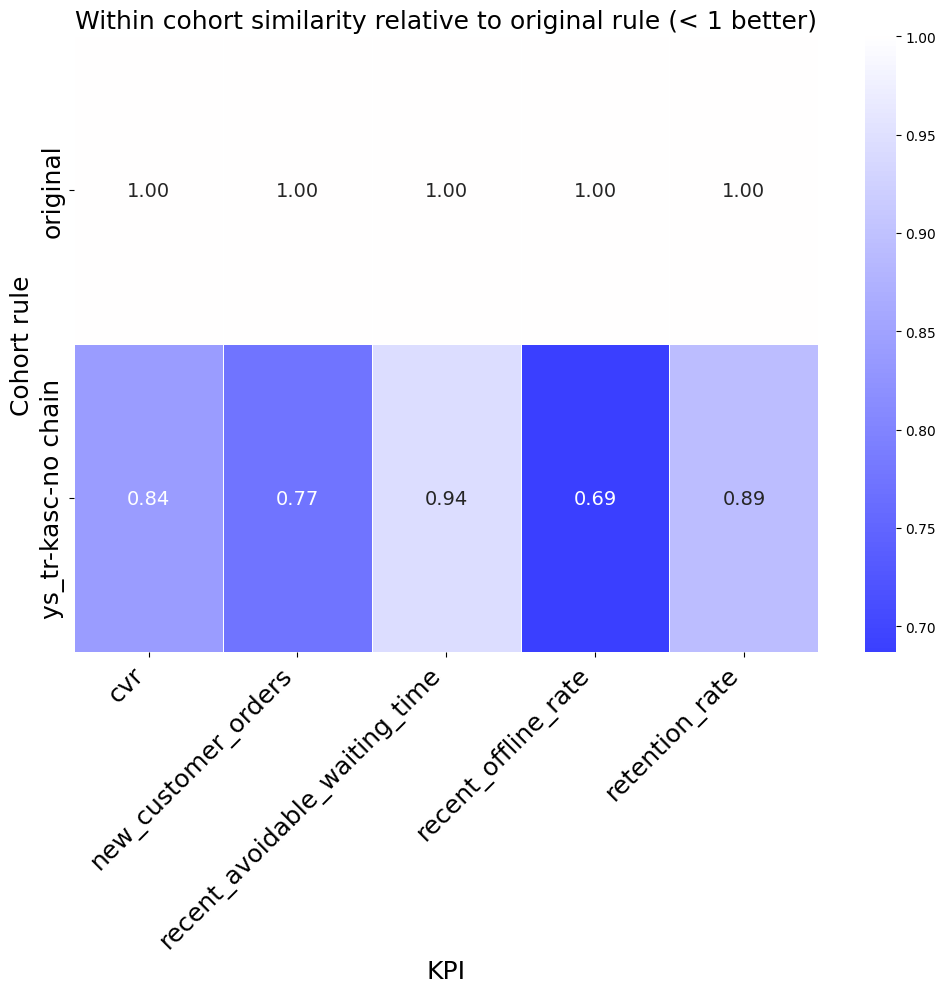

In [33]:
custom_cmap = LinearSegmentedColormap.from_list(
    'custom_diverging',
    [DH_NAVY, 'white', DH_RED]
)

fig, ax = plt.subplots(figsize=(12, 8)) 
sns.heatmap(
    df_divided.T,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap, # Use the custom colormap
    center=1.0,
    linewidths=.5,
    annot_kws={'size': 14} # Annotation size

)
ax.set_title('Within cohort similarity relative to original rule (< 1 better)', fontsize=18)
ax.set_ylabel('Cohort rule', fontsize=18)
ax.set_xlabel('KPI', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=18)
plt.yticks(fontsize=18)
new_labels = [label.get_text().replace('-recommendation (KPIs)-current', '') for label in ax.get_yticklabels()]
ax.set_yticklabels(new_labels)



plt.show()

## Step three. Recommendation quality

In [34]:
RECO_SQL_QUERY = """
SELECT 
    t.*
FROM {table_path} AS t
"""

In [35]:
table_path = "logistics-vendor-production.pa_staging.recommendations_step_3_kasc_no_chain_tr"

In [36]:
print("\n===== LOADING recommendations data =====")
reco_data_dfs = load_dataframes_by_type(
    specific_data_type="recommendation",
    base_sql_query_template=RECO_SQL_QUERY,
    config=path_config,
    project_id=BQ_PROJECT_ID
)


===== LOADING recommendations data =====
Starting to load 'recommendation' DataFrames...
------------------------------------------------------------
Reading: Key='ys_tr-original-recommendation-current'
  Table Path: logistics-vendor-production.pa_staging.recommendations_original_tr
Downloading: 100%|██████████|
  Successfully loaded 106103 rows.
------------------------------------------------------------
Reading: Key='ys_tr-kasc-no chain-recommendation-current'
  Table Path: logistics-vendor-production.pa_staging.recommendations_step_3_kasc_no_chain_tr
Downloading: 100%|██████████|
  Successfully loaded 106103 rows.
------------------------------------------------------------
Finished loading 'recommendation' DataFrames.
Total 'recommendation' DataFrames loaded: 2


In [37]:
reco_data_dfs.keys()

dict_keys(['ys_tr-original-recommendation-current', 'ys_tr-kasc-no chain-recommendation-current'])

In [38]:
try:
    reco_data_dfs['ys_tr-original-recommendation-current']
except KeyError:
    pass

In [39]:
try:
    reco_data_dfs['ys_tr-kasc-no chain-recommendation-current']
except KeyError:
    pass

In [40]:
combined_data = {}
for key in reco_data_dfs.keys():
    metrics_key = key.replace('recommendation', 'recommendation (KPIs)')
    tmp = pd.merge(
        metrics_data_dfs[metrics_key],
        reco_data_dfs[key],
        left_on=['entity_id', 'vendor_code'],
        right_on=['global_entity_id', 'vendor_id'],
        how='inner',
        indicator=True,
        suffixes=['_m', '']
    ).drop('cohort_id_m', axis=1)
    output_key = key.replace('-recommendation-', '-')
    combined_data[output_key] = tmp

In [41]:
combined_data.keys()

dict_keys(['ys_tr-original-current', 'ys_tr-kasc-no chain-current'])

In [42]:
growth_metric_mapping = {
    "VFD": ["recommend_vfd", "cvr", "cvr_percentile"],
    "CPC": ["recommend_cpc", "impressions", "impressions_percentile"],
    "Joker": ["recommend_joker", "new_customer_orders", "new_customer_orders_percentile"],
    "Targeted VFD": ["recommend_targeted_vfd", "retention_rate", "retention_rate_percentile"],
}

ops_metric_mapping = {
    "Online markup": "online_markup",
    "Fail rate": "vendor_fail_rate",
    "Offline rate": "offline_rate",
    "Ratings": "ratings",
    "Waiting time": "waiting_time",
    "Menu Content": "menu_content_score",
}

In [43]:
def get_gaps(df: pd.DataFrame, metric_columns: List[str], fill_na: bool = False) -> pd.DataFrame:
    """
    Calculates performance and percentile gaps for metrics within cohorts.

    Args:
        df (pd.DataFrame): The input DataFrame. Expected to contain:
                           - 'entity_id', 'cohort_id', 'vendor_code'
                           - The columns specified in `metric_columns`.
                           `metric_columns` should contain:
                           [0] `reco_col`: Binary (0/1) indicator for recommendation/treatment.
                           [1] `value_col`: The actual metric value (e.g., CVR, Impressions).
                           [2] `percentile_col`: The percentile of the `value_col`.
        metric_columns (List[str]): A list of 3 column names representing
                                    [reco_column, value_column, percentile_column].
        fill_na (bool): If True, fills NaN values in the `value_column` with 0
                        before calculating medians and gaps.

    Returns:
        pd.DataFrame: A DataFrame with 'entity_id', 'cohort_id', 'vendor_code',
                      'performance_gap', and 'pc_perf_gap'.

    Raises:
        ValueError: If `metric_columns` does not contain exactly 3 elements.
        KeyError: If any required base column ('entity_id', 'cohort_id', 'vendor_code')
                  or any column from `metric_columns` is missing from the input DataFrame.
    """
    if len(metric_columns) != 3:
        raise ValueError(
            "`metric_columns` must contain exactly 3 column names: "
            "[reco_column_name, value_column_name, percentile_column_name]"
        )

    reco_col, value_col, percentile_col = metric_columns[0], metric_columns[1], metric_columns[2]

    required_base_cols = ['global_entity_id', 'cohort_id', 'vendor_id']
    all_required_cols_for_gaps = required_base_cols + metric_columns

    # Check for all required columns
    missing_cols = [col for col in all_required_cols_for_gaps if col not in df.columns]
    if missing_cols:
        raise KeyError(f"Input DataFrame is missing required columns: {missing_cols}")

    # Select only relevant columns to avoid unnecessary memory usage
    tmp = df[required_base_cols + metric_columns].copy()

    # Handle NaN filling before median calculation
    if fill_na:
        tmp[value_col] = tmp[value_col].fillna(0)

    # Calculate cohort median for the value_column
    cohort_median = tmp.groupby('cohort_id')[value_col].median().rename("median_")
    tmp = pd.merge(tmp, cohort_median, on='cohort_id', how='left')

    # Ensure reco_col is numeric for comparison and handle potential non-binary values
    # Coerce errors to NaN then fill with 0, convert to int (assuming 0/1)
    tmp[reco_col] = pd.to_numeric(tmp[reco_col], errors='coerce').fillna(0).astype(int)

    # Calculate performance_gap and pc_perf_gap
    tmp = tmp.assign(
        performance_gap = lambda x: np.where(x[reco_col] == 1, x['median_'] - x[value_col], np.nan),
        pc_perf_gap = lambda x: np.where(x[reco_col] == 1, 0.5 - x[percentile_col], np.nan)
    )

    return tmp[required_base_cols + ['performance_gap', 'pc_perf_gap']]

In [44]:
calculated_gaps_dfs: Dict[str, Dict[str, pd.DataFrame]] = {}
unprocessed_df_metrics: List[str] = [] # To track any skipped combinations

print("--- Starting Gap Calculation ---")
print("=" * 60)

for metric_name, metric_columns_list in growth_metric_mapping.items():
    print(f"\nProcessing metric: '{metric_name}' (Columns: {metric_columns_list})")
    calculated_gaps_dfs[metric_name] = {} # Initialize nested dict for this metric

    for df_key, loaded_df in combined_data.items():
        print(f"  Applying to DataFrame: '{df_key}'")
        try:
            # Check if all columns required by get_gaps and the specific metric exist in loaded_df
            required_cols_for_this_df = ['entity_id', 'cohort_id', 'vendor_code'] + metric_columns_list
            if not all(col in loaded_df.columns for col in required_cols_for_this_df):
                missing = [col for col in required_cols_for_this_df if col not in loaded_df.columns]
                raise KeyError(f"Missing required columns: {missing}")

            # Call the get_gaps function
            gaps_df = get_gaps(loaded_df, metric_columns_list, fill_na=False) # Use fill_na=True as an example

            calculated_gaps_dfs[metric_name][df_key] = gaps_df
            print(f"    Successfully calculated gaps. Resulting DF shape: {gaps_df.shape}")

        except (KeyError, ValueError) as e:
            # Catch specific errors from get_gaps (missing columns, wrong metric_columns length)
            error_msg = f"Skipped '{df_key}' for '{metric_name}' due to data/config error: {e}"
            unprocessed_df_metrics.append(error_msg)
            print(f"    [SKIP] {error_msg}")
        except Exception as e:
            # Catch any other unexpected errors during processing
            error_msg = f"Failed to calculate gaps for '{df_key}' with metric '{metric_name}': {e}"
            unprocessed_df_metrics.append(error_msg)
            print(f"    [ERROR] {error_msg}")
        finally:
            print("-" * 60) # Separator for each DataFrame processing
        if df_key == 'ys_tr-original-current' and metric_name == 'Joker':
            debugging = gaps_df 

print("\n--- Gap Calculation Complete ---")
if unprocessed_df_metrics:
    print("\nSome DataFrame-metric combinations could not be processed:")
    for error in unprocessed_df_metrics:
        print(f"- {error}")
print("=" * 60)

--- Starting Gap Calculation ---

Processing metric: 'VFD' (Columns: ['recommend_vfd', 'cvr', 'cvr_percentile'])
  Applying to DataFrame: 'ys_tr-original-current'
    Successfully calculated gaps. Resulting DF shape: (106103, 5)
------------------------------------------------------------
  Applying to DataFrame: 'ys_tr-kasc-no chain-current'
    Successfully calculated gaps. Resulting DF shape: (106103, 5)
------------------------------------------------------------

Processing metric: 'CPC' (Columns: ['recommend_cpc', 'impressions', 'impressions_percentile'])
  Applying to DataFrame: 'ys_tr-original-current'
    Successfully calculated gaps. Resulting DF shape: (106103, 5)
------------------------------------------------------------
  Applying to DataFrame: 'ys_tr-kasc-no chain-current'
    Successfully calculated gaps. Resulting DF shape: (106103, 5)
------------------------------------------------------------

Processing metric: 'Joker' (Columns: ['recommend_joker', 'new_customer_o

In [45]:
combined_data['ys_tr-original-current']

,created_date,updated_at_m,entity_id,vendor_code,current_tier_m,threshold_tier_m,vendor_fail_rate_weightage,vendor_fail_rate,vendor_fail_rate_threshold,recent_vendor_fail_rate_m,...,retention_rate,retention_rate_percentile,month_over_month_retention_rate,month_over_month_cohort_retention_rate,has_active_cpc_campaigns,cpc_recently_modified,has_active_vfd_campaigns,has_targeted_vfd_campaigns,has_joker_campaigns,_merge
0,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,s1ow,None,None,NaN,NaN,NaN,0.000000,...,0.070796,0.00,NaN,2.764378,<NA>,<NA>,<NA>,<NA>,True,both
1,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,x9xo,None,None,NaN,NaN,NaN,NaN,...,NaN,0.00,NaN,0.784502,<NA>,<NA>,<NA>,<NA>,<NA>,both
2,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,yd19,None,None,NaN,NaN,NaN,5.882353,...,0.038760,0.22,NaN,1.916936,True,True,<NA>,<NA>,True,both
3,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,e4m2,None,None,NaN,NaN,NaN,0.000000,...,0.000000,0.00,NaN,1.085154,<NA>,<NA>,<NA>,<NA>,True,both
4,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,t3tq,None,None,NaN,NaN,NaN,2.540835,...,NaN,0.00,NaN,1.001484,True,<NA>,<NA>,<NA>,<NA>,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106098,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,icgt,STARTER,ADVANCED,NaN,0.20,0.8,0.000000,...,0.618421,0.71,0.964270,1.005965,True,True,<NA>,<NA>,True,both
106099,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,nrhd,STARTER,ADVANCED,NaN,1.26,0.8,0.000000,...,NaN,0.00,NaN,0.991650,<NA>,<NA>,<NA>,<NA>,<NA>,both
106100,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,k8rz,STARTER,ADVANCED,NaN,0.88,0.8,0.000000,...,0.357143,0.42,1.100000,1.046347,<NA>,<NA>,<NA>,<NA>,True,both
106101,2025-08-14,2025-08-14 08:25:00.118957+00:00,YS_TR,c79h,STARTER,ADVANCED,NaN,4.73,0.8,4.444444,...,0.246154,0.06,0.459459,0.979821,<NA>,<NA>,<NA>,<NA>,True,both


In [46]:
calculated_gaps_dfs["Joker"]['ys_tr-original-current']

,global_entity_id,cohort_id,vendor_id,performance_gap,pc_perf_gap
0,YS_TR,52275,s1ow,NaN,NaN
1,YS_TR,51230,x9xo,NaN,NaN
2,YS_TR,58663,yd19,NaN,NaN
3,YS_TR,18883,e4m2,NaN,NaN
4,YS_TR,19016,t3tq,NaN,NaN
...,...,...,...,...,...
106098,YS_TR,14063,icgt,NaN,NaN
106099,YS_TR,19063,nrhd,NaN,NaN
106100,YS_TR,32885,k8rz,NaN,NaN
106101,YS_TR,39850,c79h,NaN,NaN


In [47]:
(
    combined_data['ys_tr-original-current']
    .loc[combined_data['ys_tr-original-current'].vendor_id == 'si6i'][
        [x for x in combined_data['ys_tr-original-current'].columns if 'recommend' in x]
    ]
)

,recommend_cpc,recommend_cpc_top_up,recommend_vfd,recommend_joker,recommend_targeted_vfd,recommend_ops_online_markup,recommend_ops_fail_rate,recommend_ops_offline_rate,recommend_ops_contact_rate,recommend_ops_ratings,recommend_ops_avoidable_waiting_time,recommend_ops_menu_content_score
463,False,False,False,False,False,False,False,False,False,False,False,False


There are differences in how the rank is calculated in SQL and in 

In [48]:
tmp1 = (
    combined_data['ys_tr-original-current']
    .loc[combined_data['ys_tr-original-current'].cohort_id == 80062][
        ['vendor_code', 'recommend_joker', 'new_customer_orders', 'new_customer_orders_percentile']
        ]
)
tmp1

,vendor_code,recommend_joker,new_customer_orders,new_customer_orders_percentile


In [49]:
tmp1['percentile_rank'] = tmp1['new_customer_orders'].rank(pct=True, method='min', na_option='top')
tmp1


,vendor_code,recommend_joker,new_customer_orders,new_customer_orders_percentile,percentile_rank


In [50]:
tmp1.new_customer_orders.median()

<NA>

In [51]:
combined_data['ys_tr-original-current'].loc[combined_data['ys_tr-original-current'].cohort_id == 80062]

,created_date,updated_at_m,entity_id,vendor_code,current_tier_m,threshold_tier_m,vendor_fail_rate_weightage,vendor_fail_rate,vendor_fail_rate_threshold,recent_vendor_fail_rate_m,...,retention_rate,retention_rate_percentile,month_over_month_retention_rate,month_over_month_cohort_retention_rate,has_active_cpc_campaigns,cpc_recently_modified,has_active_vfd_campaigns,has_targeted_vfd_campaigns,has_joker_campaigns,_merge


In [52]:
# Convert nested dictionary to final_gaps_df (as per previous solution)
all_gaps_data = []
for metric_name, df_by_key_dict in calculated_gaps_dfs.items():
    for df_key, gaps_df in df_by_key_dict.items():
        df_with_meta = gaps_df.copy()
        df_with_meta['metric_name'] = metric_name
        df_with_meta['df_key'] = df_key
        all_gaps_data.append(df_with_meta)

final_gaps_df = pd.concat(all_gaps_data, ignore_index=True)
final_gaps_df = final_gaps_df[['df_key', 'metric_name', 'performance_gap', 'pc_perf_gap']]

In [53]:
final_gaps_df.groupby(['df_key', 'metric_name']).mean()

performance_gap  pc_perf_gap
df_key                      metric_name                               
ys_tr-kasc-no chain-current CPC               3125.818905     0.262538
                            Joker               -9.402227     0.337769
                            Targeted VFD         0.095235     0.274269
                            VFD                  0.003820     0.290876
ys_tr-original-current      CPC               3144.252975     0.256308
                            Joker               -8.279408     0.317680
                            Targeted VFD         0.116665     0.251691
                            VFD                  0.003539     0.284762

In [54]:
from scipy.stats import ttest_ind

In [55]:
# 1. Define the baseline key
baseline_key = 'ys_tr-original-current'
results = []

# 2. Group data by 'metric_name' to perform tests within each metric
for metric, metric_df in final_gaps_df.groupby('metric_name'):

    # Get the baseline data for the current metric
    # .dropna() is important to avoid errors with missing values
    baseline_data = metric_df[metric_df['df_key'] == baseline_key]['pc_perf_gap'].dropna()

    # If there's no baseline data for this metric, skip it
    if baseline_data.empty:
        continue

    # 3. Iterate through all other groups within the same metric
    for key, group_df in metric_df.groupby('df_key'):

        # Don't compare the baseline against itself
        if key == baseline_key:
            continue

        # Get the comparison group's data
        comparison_data = group_df['pc_perf_gap'].dropna()
        if comparison_data.empty:
            continue

        # 4. Perform Welch's t-test (more robust)
        t_stat, p_value = ttest_ind(comparison_data, baseline_data, equal_var=False)

        # Calculate the difference in means
        mean_difference = np.mean(comparison_data) - np.mean(baseline_data)

        # Append results
        results.append({
            'metric_name': metric,
            'comparison_key': key,
            'mean_difference': mean_difference,
            't_statistic': t_stat,
            'p_value': p_value
        })

# 5. Create the final results DataFrame
ttest_results_df = pd.DataFrame(results)

# --- Display Results ---
print("--- T-Test Results (Comparison vs. Global Baseline) ---")

num_comparisons = ttest_results_df.shape[0]
corrected_alpha = 0.05 / num_comparisons
print(f"To maintain a family-wise 95% confidence, the new p-value threshold is {corrected_alpha:.4f}")
print(
    "The family-wise error rate (FWER) is the probability of rejecting at least "
    "one true Hypothesis, that is, of making at least one type I error."
)

--- T-Test Results (Comparison vs. Global Baseline) ---
To maintain a family-wise 95% confidence, the new p-value threshold is 0.0125
The family-wise error rate (FWER) is the probability of rejecting at least one true Hypothesis, that is, of making at least one type I error.


In [56]:
ttest_results_df

,metric_name,comparison_key,mean_difference,t_statistic,p_value
0,CPC,ys_tr-kasc-no chain-current,0.006230,4.056482,4.991919e-05
1,Joker,ys_tr-kasc-no chain-current,0.020089,7.349319,2.095670e-13
2,Targeted VFD,ys_tr-kasc-no chain-current,0.022578,7.235428,4.946225e-13
3,VFD,ys_tr-kasc-no chain-current,0.006115,3.616188,2.993645e-04


In [57]:
def plot_performance_grid(
    summary_df: pd.DataFrame,
    plot_title: str,
    y_label: str = 'Mean Performance Gap', # Re-introduced y-label for individual plots
    facet_col: str = 'metric_name',
    group_by_col: str = 'model_name',
    sub_group_by_col: str = 'df_key',
    mean_col: str = 'performance_gap_mean',
    figure_size: Tuple[float, float] = (12, 10),
    save_path: Optional[str] = None,
    show_plot: bool = True
) -> None:
    """
    Generates a 2x2 grid of grouped bar plots with independent Y-axes.

    Args:
        summary_df (pd.DataFrame): DataFrame with aggregated data.
        plot_title (str): The main title for the entire figure.
        y_label (str): The label for the y-axis of each subplot.
        facet_col (str): Column whose unique values define each subplot. Max 4.
        group_by_col (str): Column for the x-axis of each subplot.
        sub_group_by_col (str): Column for sub-grouping (hue) within each subplot.
        mean_col (str): Column with mean values for bar heights.
        figure_size (Tuple[float, float]): Size of the entire figure.
        save_path (Optional[str]): Path to save the figure.
        show_plot (bool): If True, displays the plot.
    """
    # --- 1. Validation and Setup ---
    required_cols = [facet_col, group_by_col, sub_group_by_col, mean_col]
    if not all(col in summary_df.columns for col in required_cols):
        missing = [col for col in required_cols if col not in summary_df.columns]
        raise ValueError(f"Input summary_df is missing required columns: {missing}")

    metrics = summary_df[facet_col].unique()
    if len(metrics) > 4:
        raise ValueError(f"This function supports up to 4 metrics, but {len(metrics)} were found.")

    # --- 2. Create Consistent Color Palette ---
    hue_order = sorted(summary_df[sub_group_by_col].unique())
    palette = dict(zip(hue_order, sns.color_palette('viridis', n_colors=len(hue_order))))

    # --- 3. Create 2x2 Subplot Grid with Independent Y-Axes ---
    # CHANGED: sharey is now False to allow independent y-axis ranges.
    fig, axes = plt.subplots(2, 2, figsize=figure_size, sharey=False)
    axes_flat = axes.flatten()

    # --- 4. Iterate and Plot on Each Axis ---
    for i, metric in enumerate(metrics):
        ax = axes_flat[i]
        metric_df = summary_df[summary_df[facet_col] == metric]

        sns.barplot(
            data=metric_df,
            x=group_by_col,
            y=mean_col,
            hue=sub_group_by_col,
            hue_order=hue_order,
            palette=palette,
            ax=ax,
            errorbar=('ci', 95),
            capsize=0.1,
            err_kws={'color': 'gray','linewidth': 1.5},
        )

        ax.set_title(metric.replace('_', ' ').title(), fontsize=16)
        ax.axhline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.7)
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45, labelsize=16)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        ax.set_xticklabels([])
        ax.set_ylabel(y_label)

        if ax.get_legend() is not None:
            ax.get_legend().remove()

    # --- 5. Clean Up and Finalize Figure ---
    for i in range(len(metrics), len(axes_flat)):
        axes_flat[i].set_visible(False)

    # CHANGED: Removed fig.supylabel and added a figure-level x-label.
    fig.supxlabel(group_by_col.replace('_', ' ').title(), y=0.02)

    legend_patches = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]
    fig.legend(
        handles=legend_patches,
        title=sub_group_by_col.replace('_', ' ').title(),
        bbox_to_anchor=(1.01, 0.95),
        loc='upper left',
        fontsize=16
    )

    fig.suptitle(plot_title, fontsize=16, y=0.98)
    plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])

    # --- 6. Saving and Showing Logic ---
    if save_path:
        # ... (saving logic remains the same)
        output_dir = os.path.dirname(save_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)

--- Plotting Mean Performance Gap (Grouped Bar Plot) ---
Plot saved to: /Users/patrick.doupe/DH/ad_hoc/cohorts/figures/mean_performance_gap_grouped_barplot.png


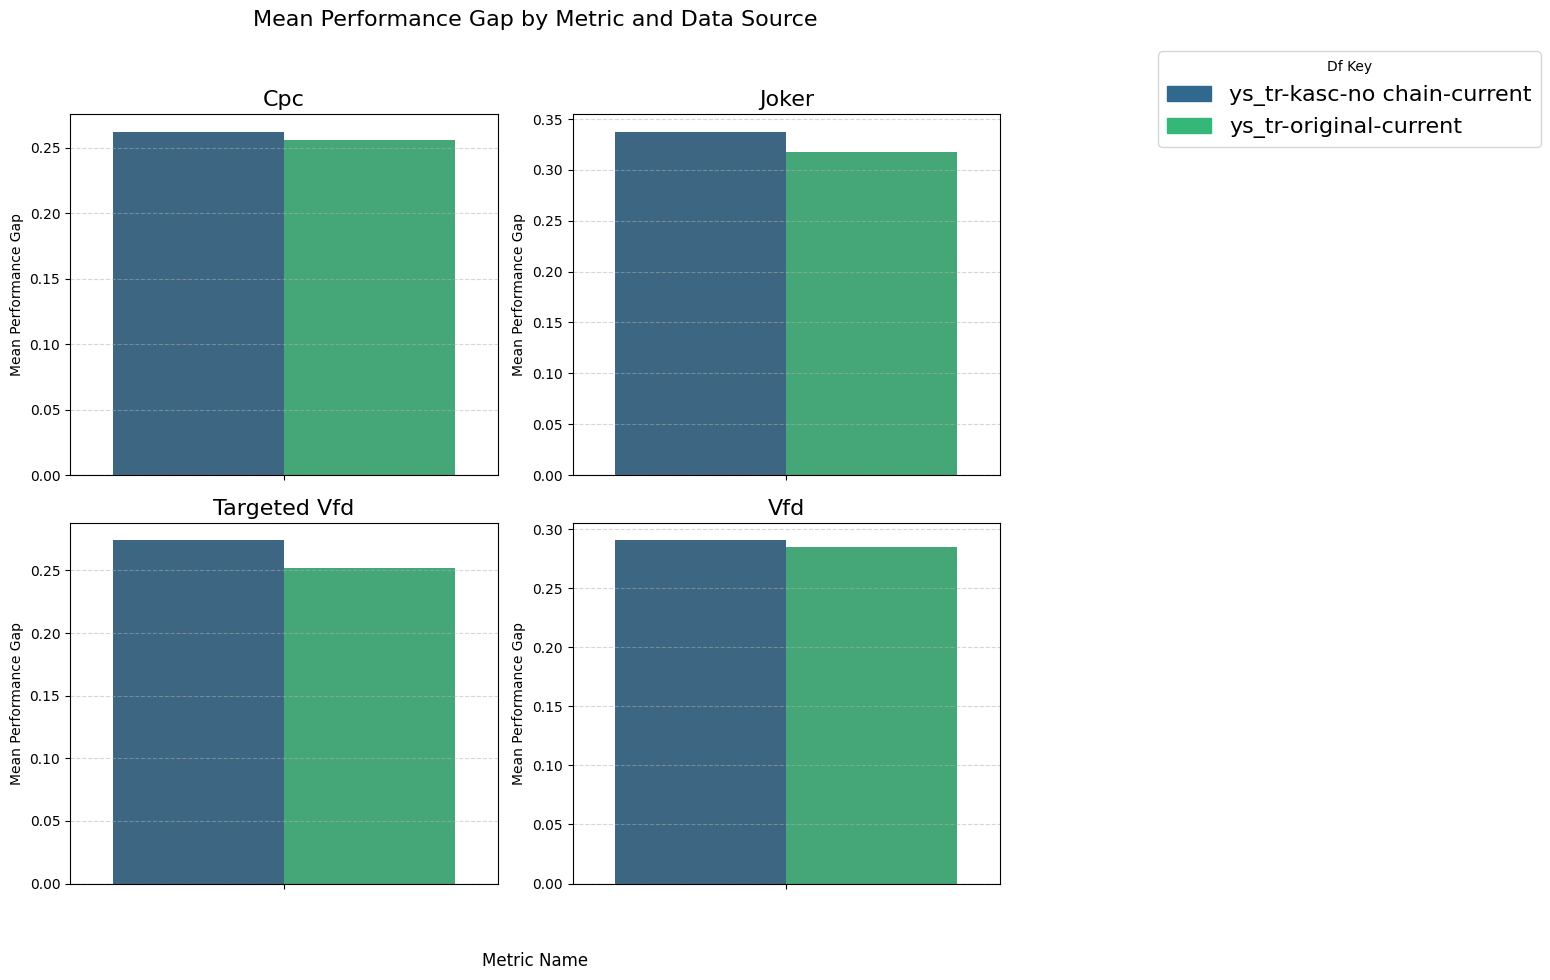

In [67]:
# Call 1: Plotting Performance Gap with 95% CI
print("--- Plotting Mean Performance Gap (Grouped Bar Plot) ---")
plot_performance_grid(
    summary_df=final_gaps_df.groupby(['df_key', 'metric_name']).pc_perf_gap.mean().reset_index(),
    plot_title='Mean Performance Gap by Metric and Data Source',
    facet_col='metric_name',
    group_by_col='metric_name', # X-axis
    sub_group_by_col='df_key',   # Hue
    mean_col='pc_perf_gap',
    save_path=BASE_PLOT_PATH / 'mean_performance_gap_grouped_barplot.png',
    show_plot=True
)

In [59]:
df_mean_gaps = final_gaps_df.groupby(['df_key', 'metric_name']).performance_gap.mean().reset_index()
df_mean_gaps.pivot_table(index='metric_name', columns='df_key', values='performance_gap')

df_key,ys_tr-kasc-no chain-current,ys_tr-original-current
metric_name,,
CPC,3125.818905,3144.252975
Joker,-9.402227,-8.279408
Targeted VFD,0.095235,0.116665
VFD,0.003820,0.003539


In [68]:
df_mean_gaps = final_gaps_df.groupby(['df_key', 'metric_name']).pc_perf_gap.mean().reset_index()
df_gap_pivoted = df_mean_gaps.pivot_table(index='metric_name', columns='df_key', values='pc_perf_gap')
df_gap_pivoted = df_gap_pivoted.div(df_gap_pivoted['ys_tr-original-current'], axis=0)
df_gap_pivoted

df_key,ys_tr-kasc-no chain-current,ys_tr-original-current
metric_name,,
CPC,1.024308,1.0
Joker,1.063236,1.0
Targeted VFD,1.089707,1.0
VFD,1.021473,1.0


In [69]:
df_pivoted = df_outlier.pivot_table(index='value', columns='df_name', values='ms_w_manual')
df_divided = df_pivoted.div(df_pivoted['original'], axis=0)
df_divided

df_name,original,ys_tr-kasc-no chain-recommendation (KPIs)-current
value,,
cvr,1.0,0.839697
new_customer_orders,1.0,0.772637
recent_avoidable_waiting_time,1.0,0.943866
recent_offline_rate,1.0,0.686768
retention_rate,1.0,0.893345


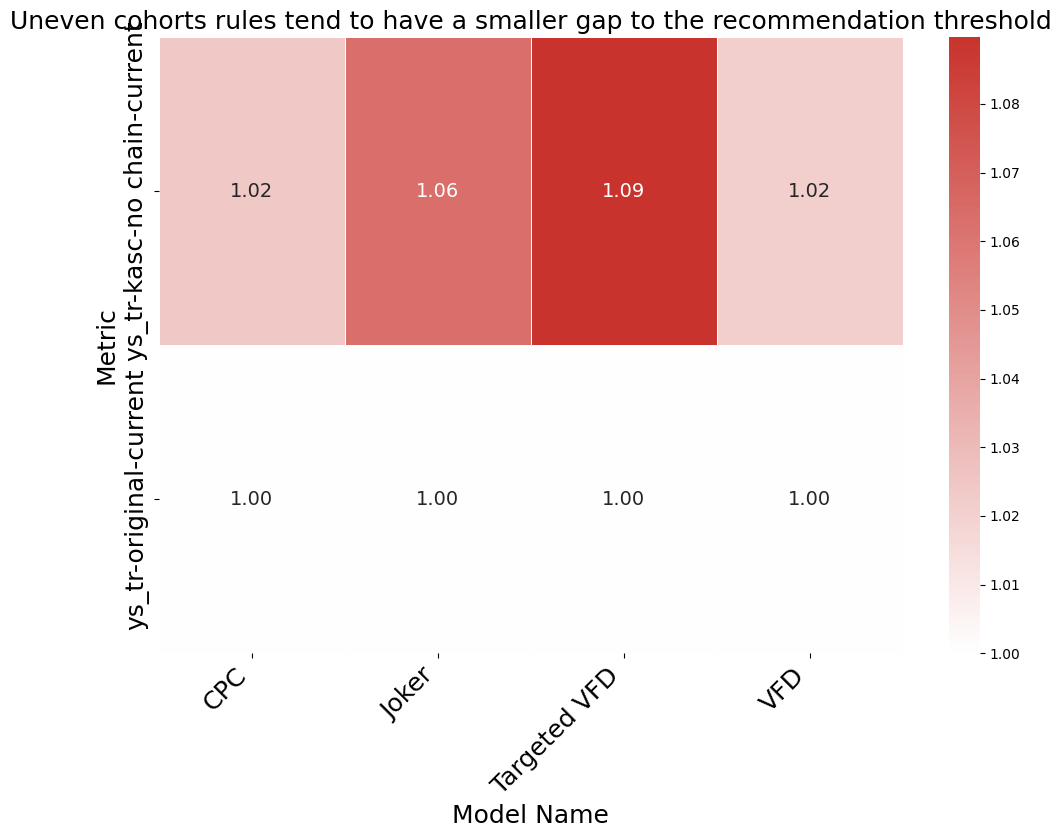

In [ ]:
custom_cmap = LinearSegmentedColormap.from_list(
    'custom_diverging',
    [DH_NAVY, 'white', DH_RED]
)

# 3. Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    df_gap_pivoted.T,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap, # Use the custom colormap
    center=1.0,
    linewidths=.5,
    annot_kws={'size': 14} # Annotation size
)
plt.title('TY: we tend to have a higher gap to the median', fontsize=18)
plt.ylabel('Metric', fontsize=18)
plt.xlabel('Model Name', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=18)

plt.show()

In [63]:
reco_data_dfs.keys()

dict_keys(['ys_tr-original-recommendation-current', 'ys_tr-kasc-no chain-recommendation-current'])

In [64]:
all_columns = reco_data_dfs['ys_tr-original-recommendation-current'].columns
reco_cols = [x for x in all_columns if 'recommend_' in x]

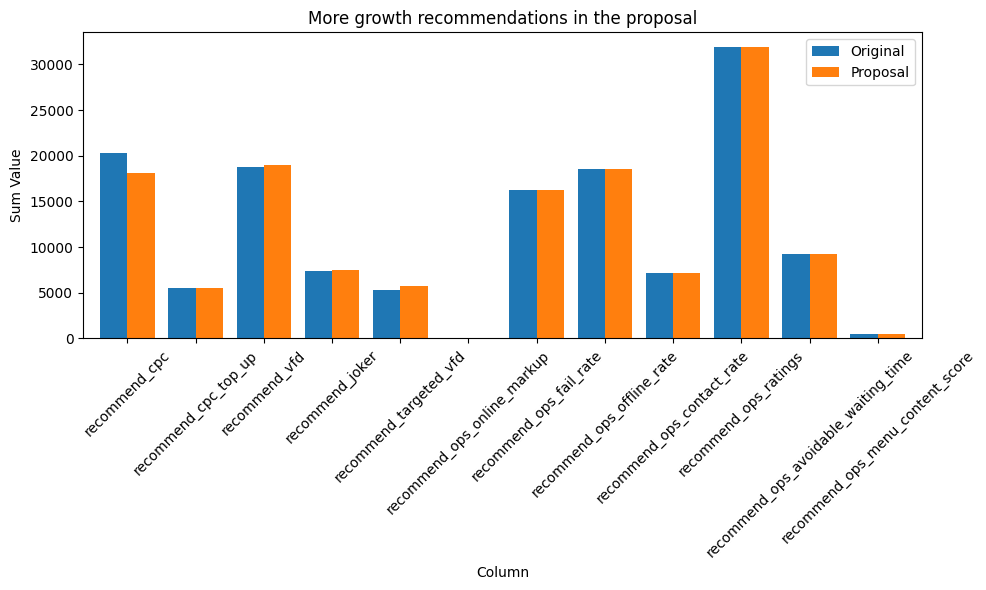

In [65]:

# Calculate the sum for each DataFrame and relevant columns
original = reco_data_dfs['ys_tr-original-recommendation-current'][reco_cols].sum()
proposal = reco_data_dfs['ys_tr-kasc-no chain-recommendation-current'][reco_cols].sum()

# Combine these sums into a single DataFrame for plotting
df_plot = pd.DataFrame({
    'Original': original,
    'Proposal': proposal
})

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
df_plot.plot(kind='bar', ax=ax, width=0.8)

ax.set_title('More growth recommendations in the proposal')
ax.set_xlabel('Column')
ax.set_ylabel('Sum Value')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()


In [66]:

# Calculate the sum for each DataFrame and relevant columns
sum_reco_no_chain = reco_data_dfs['ys_tr-original-recommendation-current'][reco_cols].sum()
sum_reco = reco_data_dfs['ys_tr-kasc-no chain-recommendation-current'][reco_cols].sum()
sum_no_chain = reco_data_dfs['no chain logic-even-recommendation-current'][reco_cols].sum()
sum_base = reco_data_dfs['base-even-recommendation-original'][reco_cols].sum()

# Combine these sums into a single DataFrame for plotting
df_plot = pd.DataFrame({
    'KASC-no chain': sum_reco_no_chain,
    'KASC': sum_reco,
    'No Chain Logic': sum_no_chain,
    'Original': sum_base
})

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
df_plot.plot(kind='bar', ax=ax, width=0.8)

ax.set_title('Recommendations are largely similar')
ax.set_xlabel('Column')
ax.set_ylabel('Sum Value')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()


KeyError: 'no chain logic-even-recommendation-current'